Importing Data from Kaggle

In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'world-happiness-report-2023:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F3031959%2F5212373%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240324%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240324T223645Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D45e491d310cff8be628f9a64ede66ca545217536b018d2aaa8769e57f8e963ba70512cada41556ab00d21b88ab574fe894fd6b849d16a0985c4c6ccbdcab025b5c868e353d0ee8632f555d076283e0ca9c2c55518172df562e49999ed68380cdddda16b6fa1dace9461b79d72c0a013628e45fb8a44c3411c8611f66daac4d7064c055e9724a7f00e59906bd2f9918006ca53bcf7543c99869ccaf30fa236bcd8c49e749818ef9e0116d008413e942306d823f452fcae1b31544d8a67516875fb14aae4d989e4cdb5091f8f11cbdae0742e6db88766616ec3ed6a42ecb7fd3123bc4fdee6015677428b0f4c645b6804d460f831ff53b7d770e7a5a458286d871'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 7319 bytes downloaded
Downloaded and uncompressed: world-happiness-report-2023
Data source import complete.


Importing Libraries

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import FunctionTransformer
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

Loading Dataset

In [3]:
data = pd.read_csv("/kaggle/input/world-happiness-report-2023/WHR2023.csv")

EDA Graphs

                              Logged GDP per capita  Social support  \
Logged GDP per capita                      1.000000        0.738069   
Social support                             0.738069        1.000000   
Healthy life expectancy                    0.837533        0.725524   
Freedom to make life choices               0.451439        0.541630   
Generosity                                -0.156456        0.036574   
Perceptions of corruption                 -0.436961       -0.272490   

                              Healthy life expectancy  \
Logged GDP per capita                        0.837533   
Social support                               0.725524   
Healthy life expectancy                      1.000000   
Freedom to make life choices                 0.415092   
Generosity                                  -0.135036   
Perceptions of corruption                   -0.404396   

                              Freedom to make life choices  Generosity  \
Logged GDP per capita       

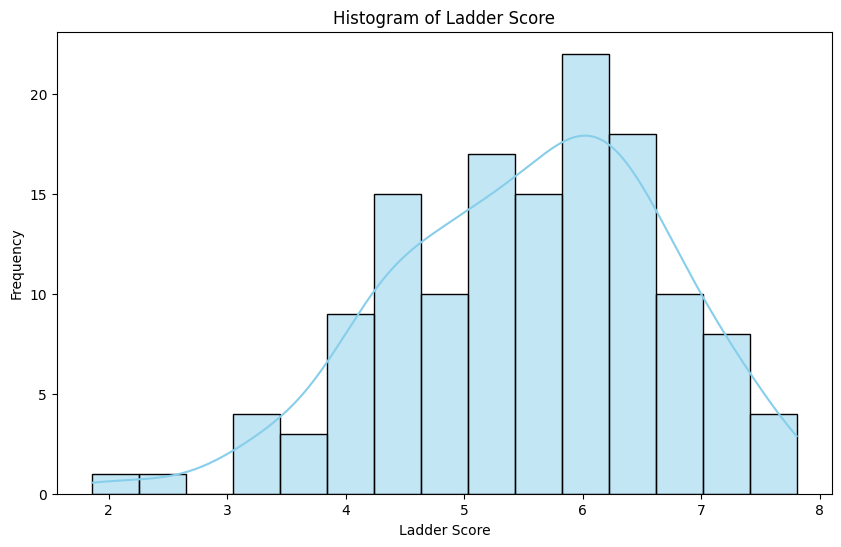

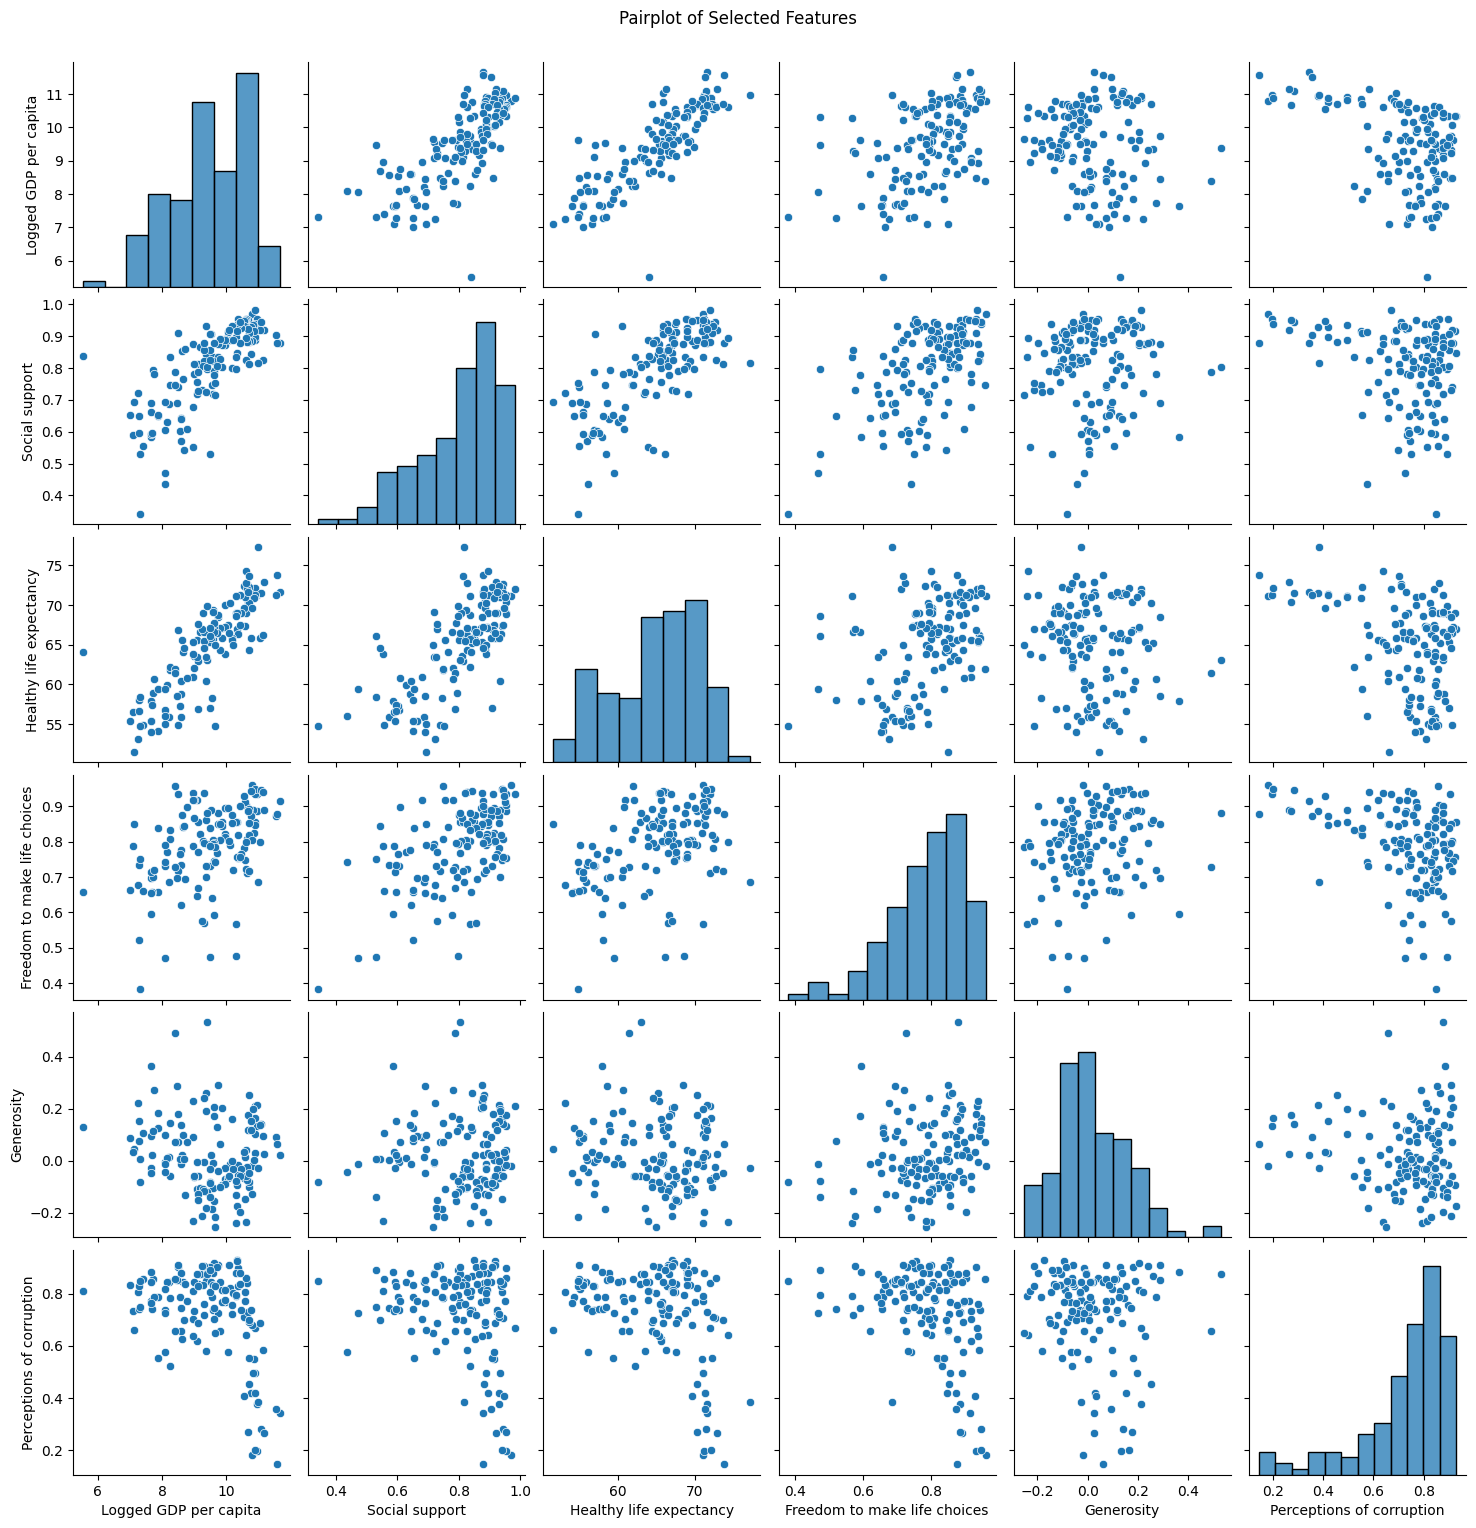

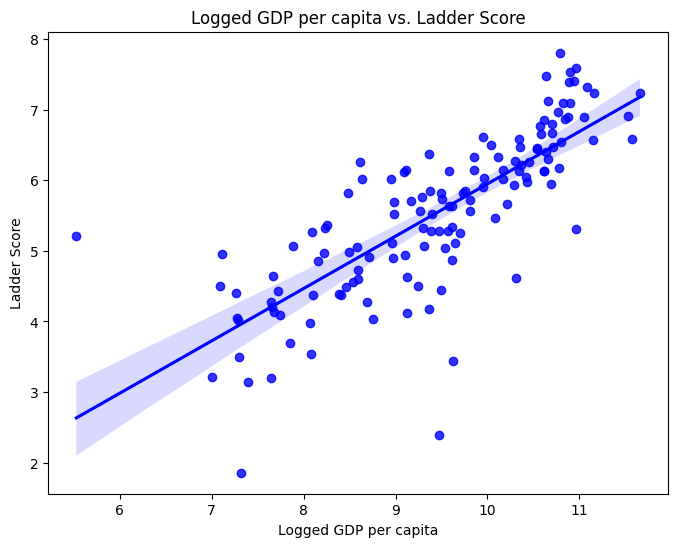

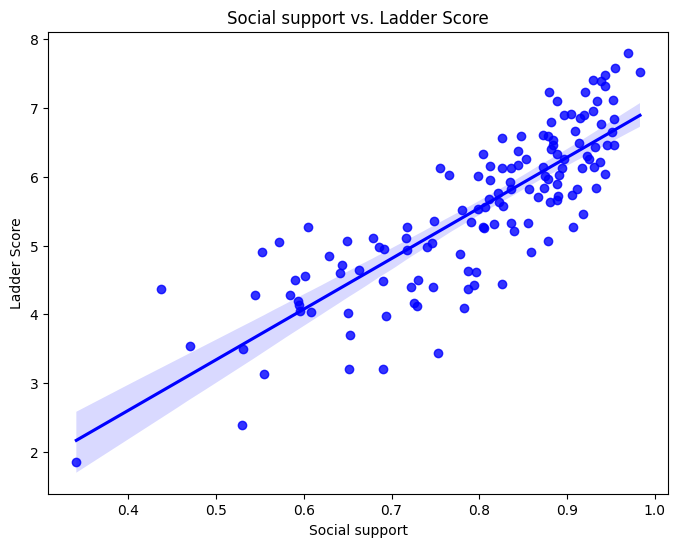

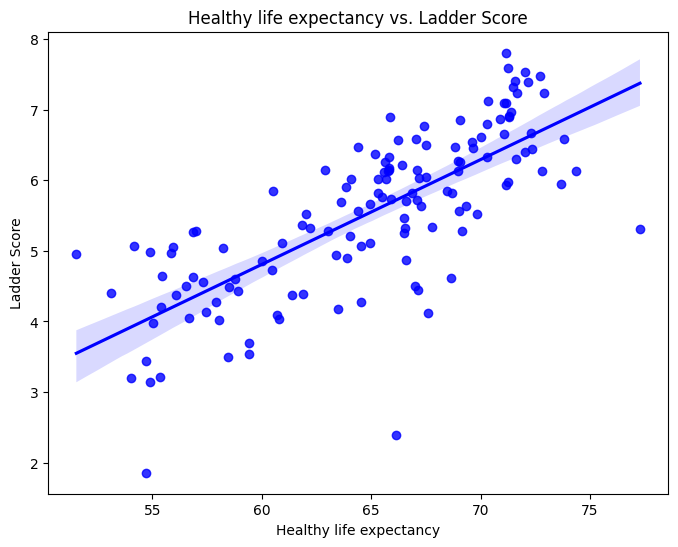

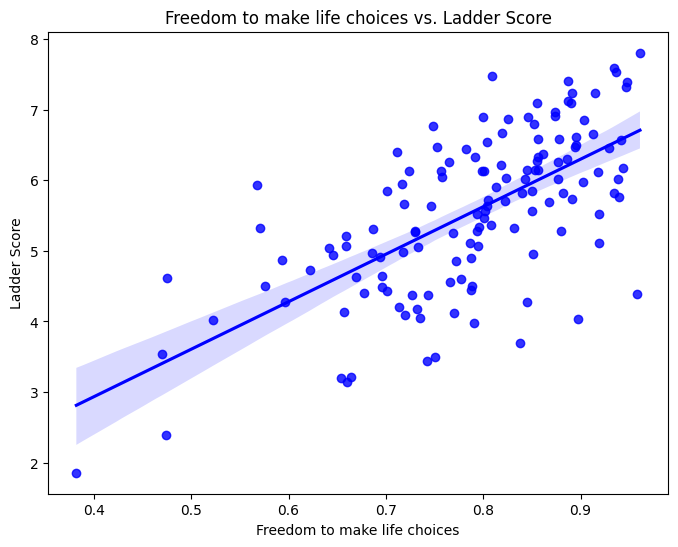

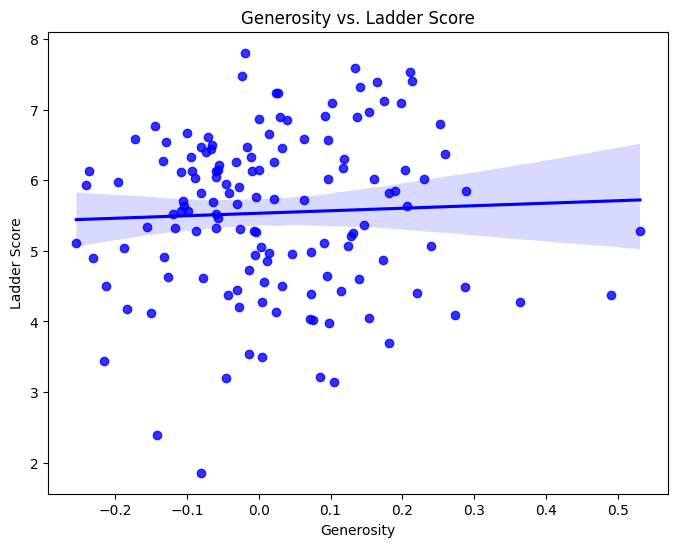

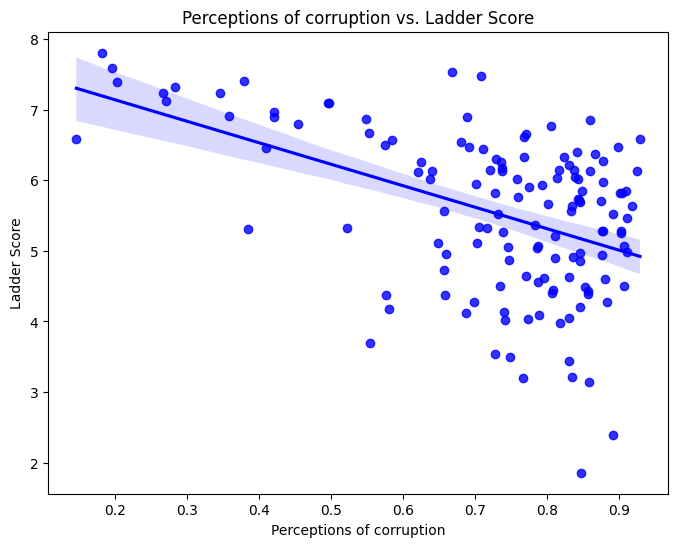

<ipython-input-4-943efbbaf567>:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=correlation_table.values, y=correlation_table.index, palette='viridis')


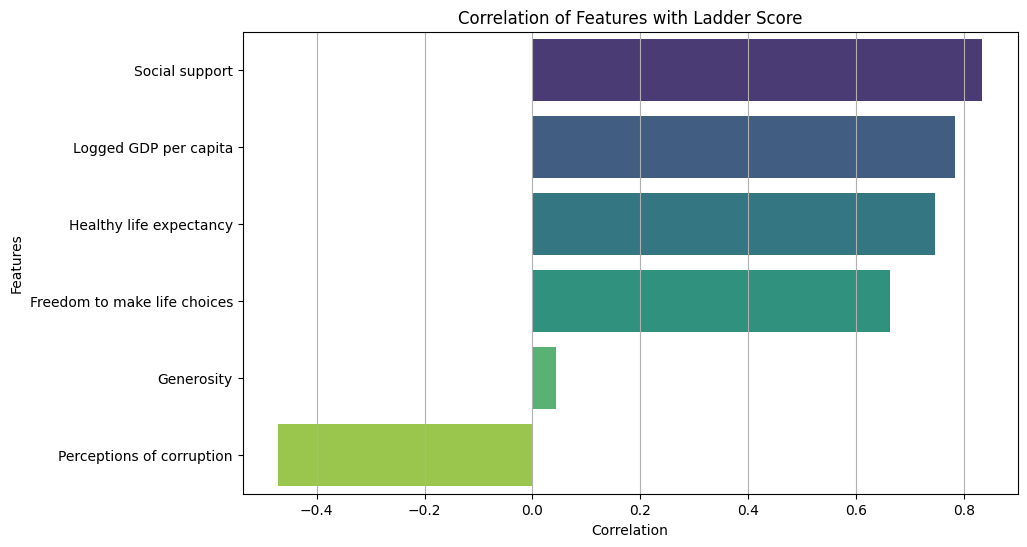

Top 3 highly correlated features:
Social support: 0.8345316508727755
Logged GDP per capita: 0.7843673131322437
Healthy life expectancy: 0.7469281602944295


In [4]:
# Correlation Table
selected_features = ['Logged GDP per capita', 'Social support', 'Healthy life expectancy',
                     'Freedom to make life choices', 'Generosity', 'Perceptions of corruption']
correlation_table = data[selected_features].corr(numeric_only=True)
print(correlation_table)

# Histogram of Ladder Score
plt.figure(figsize=(10, 6))
sns.histplot(data['Ladder score'], bins=15, kde=True, color='skyblue')
plt.title('Histogram of Ladder Score')
plt.xlabel('Ladder Score')
plt.ylabel('Frequency')
plt.show()

# Pairplot of Selected Features
sns.pairplot(data[selected_features])
plt.suptitle('Pairplot of Selected Features', y=1.02)
plt.show()


# Plot features
for feature in selected_features:
    plt.figure(figsize=(8, 6))
    sns.regplot(x=feature, y='Ladder score', data=data, color='blue')
    plt.title(f'{feature} vs. Ladder Score')
    plt.xlabel(feature)
    plt.ylabel('Ladder Score')
    plt.show()

# Plot correlation values for each feature
plt.figure(figsize=(10, 6))
correlation_table = data[selected_features].corrwith(data['Ladder score']).sort_values(ascending=False)
sns.barplot(x=correlation_table.values, y=correlation_table.index, palette='viridis')
plt.title('Correlation of Features with Ladder Score')
plt.xlabel('Correlation')
plt.ylabel('Features')
plt.grid(axis='x')
plt.show()

# Sort correlation values in descending order
sorted_correlation = correlation_table.abs().sort_values(ascending=False)

# Select the top 3 highly correlated features
top_3_features = sorted_correlation.index[:3].tolist()

# Print the top 3 highly correlated features along with their correlation values
print("Top 3 highly correlated features:")
for feature in top_3_features:
    correlation_value = correlation_table.loc[feature]
    print(f"{feature}: {correlation_value}")


Preprocessing and Regression model training

Performance Metrics:
                          Model  Mean Squared Error  R-squared
0             Linear Regression        1.461316e-07   1.000000
1      Random Forest Regression        2.356780e-03   0.998101
2  Gradient Boosting Regression        3.098134e-03   0.997504

Best performing algorithm: Linear Regression


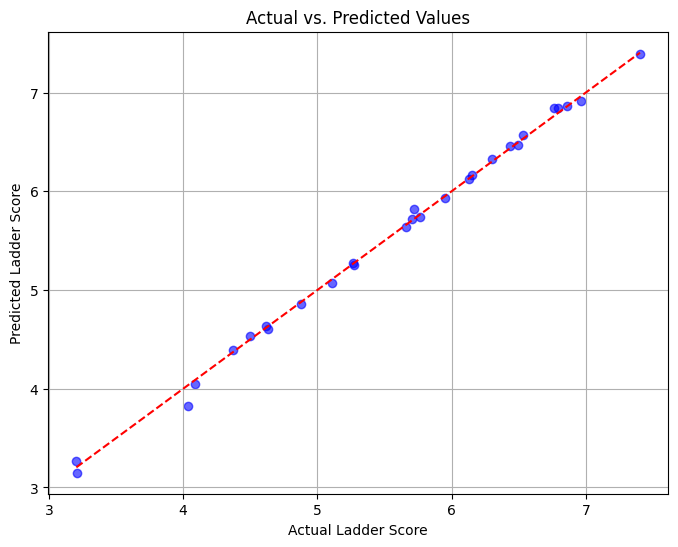

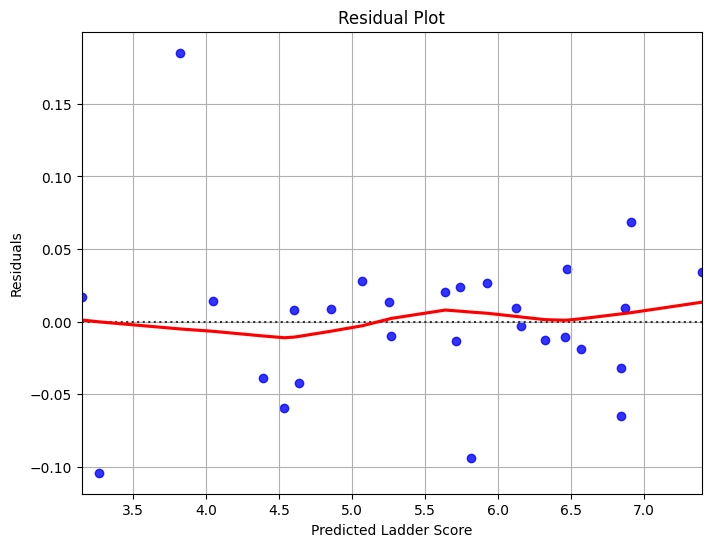

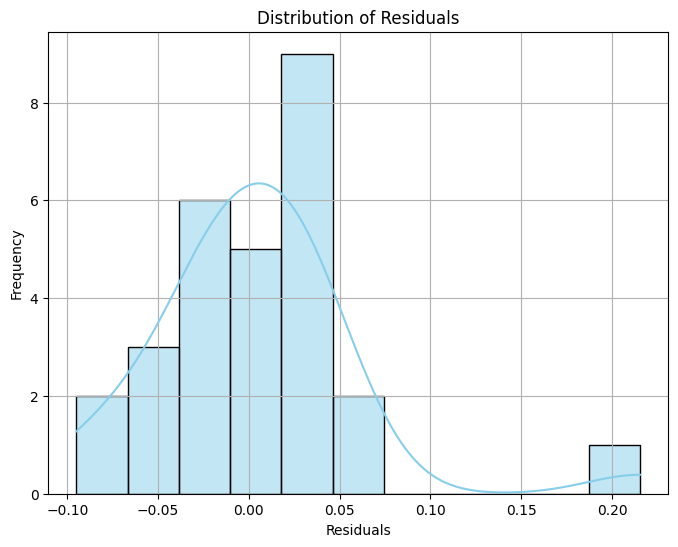

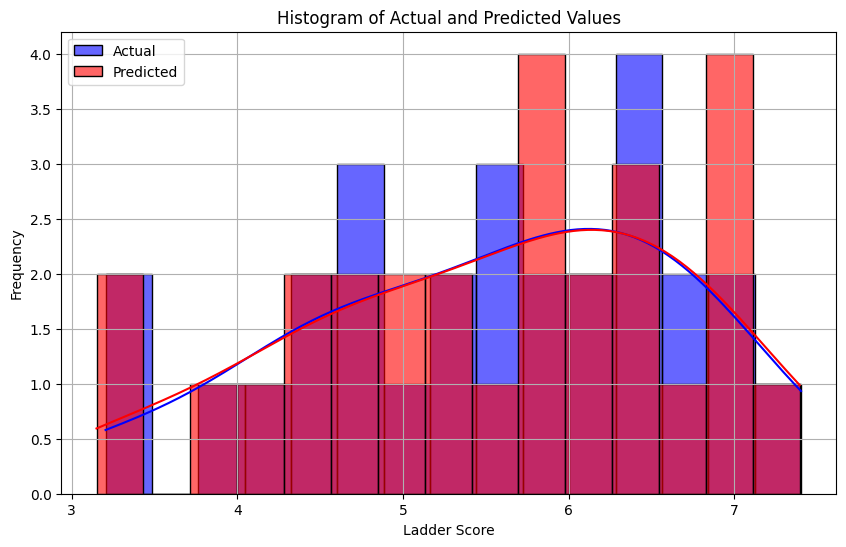

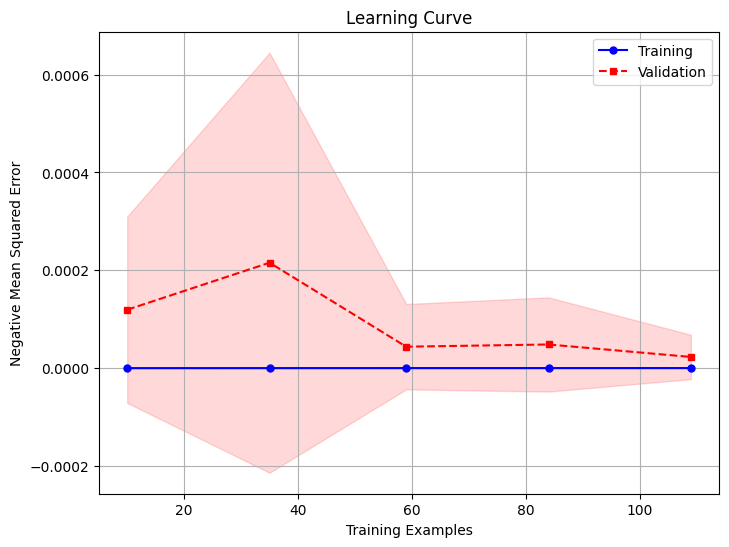

In [8]:
# Split features and target variable
X = data.drop(['Ladder score', 'Country name'], axis=1)
y = data['Ladder score']

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Preprocessing pipeline
numeric_features = X.select_dtypes(include=['float64']).columns

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features)
    ])

# Define models
models = [
    ('Linear Regression', LinearRegression()),
    ('Random Forest Regression', RandomForestRegressor(random_state=42)),
    ('Gradient Boosting Regression', GradientBoostingRegressor(random_state=42))
]

results = []

# Train and evaluate models
for name, model in models:
    model_pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', model)
    ])
    model_pipeline.fit(X_train, y_train)
    y_pred = model_pipeline.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    results.append((name, mse, r2))

# Display results
results_df = pd.DataFrame(results, columns=['Model', 'Mean Squared Error', 'R-squared'])
print("Performance Metrics:")
print(results_df)

# Identify the best-performing algorithm
best_model_idx = results_df['Mean Squared Error'].idxmin()
best_model_name = results_df.loc[best_model_idx, 'Model']
best_model = models[best_model_idx][1]
print(f"\nBest performing algorithm: {best_model_name}")

# Train the best model on the entire dataset
best_model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', best_model)
])
best_model_pipeline.fit(X, y)

# Graph 1: Scatter plot of actual vs. predicted values
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, color='blue', alpha=0.6)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
plt.title('Actual vs. Predicted Values')
plt.xlabel('Actual Ladder Score')
plt.ylabel('Predicted Ladder Score')
plt.grid(True)
plt.show()

# Graph 2: Residual plot
residuals = y_test - y_pred
plt.figure(figsize=(8, 6))
sns.residplot(x=y_pred, y=residuals, lowess=True, color='blue', line_kws={'color': 'red'})
plt.title('Residual Plot')
plt.xlabel('Predicted Ladder Score')
plt.ylabel('Residuals')
plt.grid(True)
plt.show()

# Graph 3: Distribution plot of residuals
plt.figure(figsize=(8, 6))
sns.histplot(residuals, kde=True, color='skyblue')
plt.title('Distribution of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Graph 4: Histogram of actual and predicted values
plt.figure(figsize=(10, 6))
sns.histplot(y_test, bins=15, kde=True, color='blue', alpha=0.6, label='Actual')
sns.histplot(y_pred, bins=15, kde=True, color='red', alpha=0.6, label='Predicted')
plt.title('Histogram of Actual and Predicted Values')
plt.xlabel('Ladder Score')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.show()

# Graph 5: Learning curve
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(best_model_pipeline, X, y, cv=5, scoring='neg_mean_squared_error')
train_mean = -np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = -np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.figure(figsize=(8, 6))
plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='Training')
plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')
plt.plot(train_sizes, test_mean, color='red', linestyle='--', marker='s', markersize=5, label='Validation')
plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, alpha=0.15, color='red')
plt.title('Learning Curve')
plt.xlabel('Training Examples')
plt.ylabel('Negative Mean Squared Error')
plt.legend()
plt.grid(True)
plt.show()
